In [62]:
import chromadb
import pandas as pd
import numpy as np

chroma_path = "../chroma_db"
client = chromadb.PersistentClient(path=chroma_path)

collection = client.get_collection(name='tweets', )

In [63]:
data = collection.get(include=["embeddings", "metadatas"])

embeddings = data["embeddings"]

labels = [item["airline_sentiment"] for item in data["metadatas"]]

    

<h1 style="color:orange;"> split data ! </h1>



In [64]:
from sklearn.model_selection import train_test_split

X = np.array(embeddings)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(
    
X,
y,
random_state=42,
test_size=0.2,
stratify=y
)

In [65]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier


In [66]:
encoder = LabelEncoder()

y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.fit_transform(y_test)

# Get the class names for the plot later

classes = encoder.classes_
n_classes = len(classes)

print(f"Encoded classes: {classes}")

Encoded classes: ['negative' 'neutral' 'positive']


In [67]:
# Training Logistic Regression 

print("\nTraining Logistic Regression...")

model_lr1 = OneVsRestClassifier(LogisticRegression(max_iter=1000))
model_lr1.fit(X_train, y_train_enc)



Training Logistic Regression...


,estimator,LogisticRegre...max_iter=1000)
,n_jobs,None
,verbose,0
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None


In [68]:
# --- CODE FOR EVALUATION ---

class_names = [str(c) for c in classes]

y_pred = model_lr1.predict(X_test)

print(f"\nAccuracy: {accuracy_score(y_test_enc, y_pred):.4f}")
print("\n--- Detailed Classification Report ---")
print(classification_report(y_test_enc, y_pred, target_names=class_names))


Accuracy: 0.8186

--- Detailed Classification Report ---
              precision    recall  f1-score   support

    negative       0.86      0.93      0.89      1832
     neutral       0.69      0.62      0.65       618
    positive       0.79      0.65      0.71       471

    accuracy                           0.82      2921
   macro avg       0.78      0.73      0.75      2921
weighted avg       0.81      0.82      0.81      2921



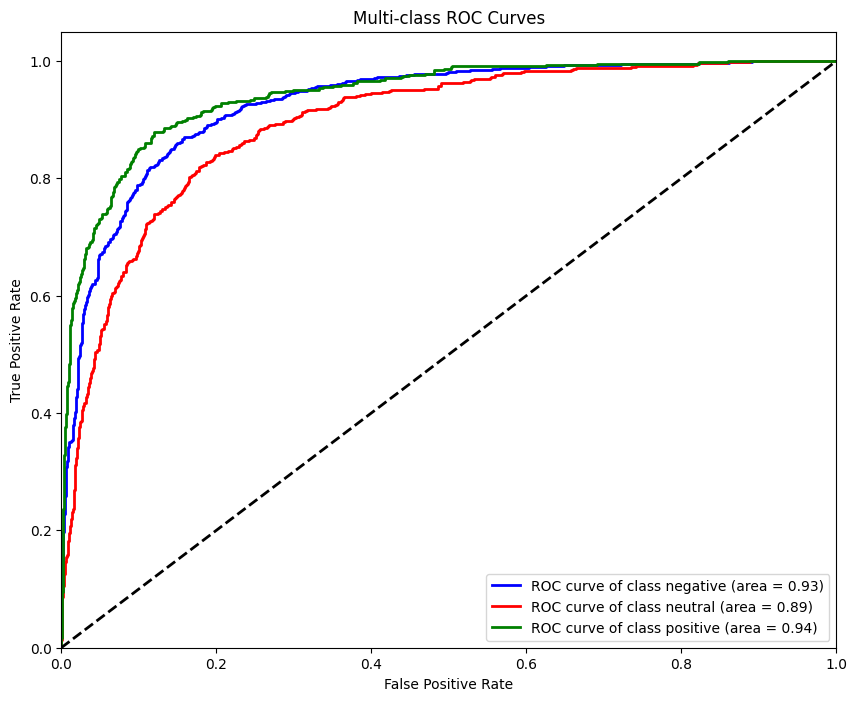

In [69]:




# ROC / AUC  

y_score = model_lr1.predict_proba(X_test)

y_test_bin = label_binarize(y_test_enc, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2) # Diagonal line (random guess)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curves')
plt.legend(loc="lower right")
plt.show()

In [70]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# Training Model 2: SVM

svm = LinearSVC(dual=False, random_state=42)
clf_svm = CalibratedClassifierCV(svm) 

clf_svm.fit(X_train, y_train_enc)

# Predict
y_pred_svm = clf_svm.predict(X_test)
y_score_svm = clf_svm.predict_proba(X_test)

print(f"SVM Accuracy: {accuracy_score(y_test_enc, y_pred_svm):.4f}")

SVM Accuracy: 0.8216


In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV


# Logistic Regression
model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(X_train, y_train_enc)

# Random Forest
model_rf = RandomForestClassifier(n_estimators=50, random_state=42)
model_rf.fit(X_train, y_train_enc)

# SVM 

# LinearSVC is fast, but doesn't give probabilities by default.
# We wrap it in CalibratedClassifierCV to get probabilities for the ROC curve.
svm_base = LinearSVC(dual=False, random_state=42)
model_svm = CalibratedClassifierCV(svm_base)
model_svm.fit(X_train, y_train_enc)



,estimator,LinearSVC(dua...ndom_state=42)
,method,'sigmoid'
,cv,None
,n_jobs,None
,ensemble,'auto'
,penalty,'l2'
,loss,'squared_hinge'
,dual,False
,tol,0.0001
,C,1.0
,multi_class,'ovr'


In [72]:
from sklearn.metrics import accuracy_score, classification_report

# Predict
y_pred_lr = model_lr.predict(X_test)
y_pred_rf = model_rf.predict(X_test)
y_pred_svm = model_svm.predict(X_test)

# Accuracy Scores
acc_lr = accuracy_score(y_test_enc, y_pred_lr)
acc_rf = accuracy_score(y_test_enc, y_pred_rf)
acc_svm = accuracy_score(y_test_enc, y_pred_svm)

print(f"Logistic Regression Accuracy: {acc_lr:.4f}")
print(f"Random Forest Accuracy:       {acc_rf:.4f}")
print(f"SVM Accuracy:                 {acc_svm:.4f}")



Logistic Regression Accuracy: 0.8172
Random Forest Accuracy:       0.7624
SVM Accuracy:                 0.8216



--- Detailed Report (Logistic Regression) ---
              precision    recall  f1-score   support

    negative       0.87      0.92      0.89      1832
     neutral       0.67      0.63      0.65       618
    positive       0.79      0.67      0.72       471

    accuracy                           0.82      2921
   macro avg       0.78      0.74      0.76      2921
weighted avg       0.81      0.82      0.81      2921



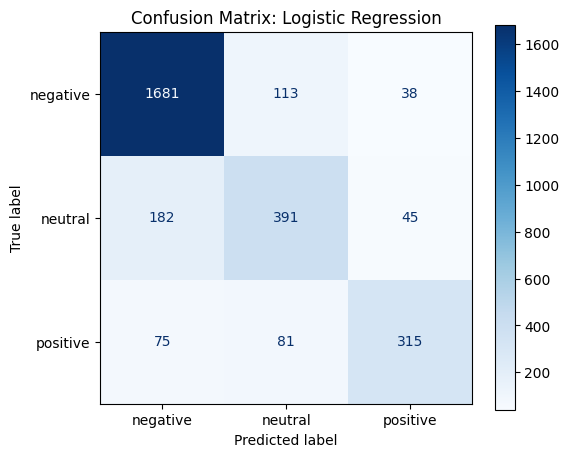

In [73]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("\n--- Detailed Report (Logistic Regression) ---")
print(classification_report(y_test_enc, y_pred_lr, target_names=class_names)) 

# Plot Confusion Matrix for Logistic Regression
plt.figure(figsize=(6, 5))
cm_lr = confusion_matrix(y_test_enc, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=class_names)
disp_lr.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title('Confusion Matrix: Logistic Regression')
plt.show()


--- Detailed Report (Random Forest) ---
              precision    recall  f1-score   support

    negative       0.77      0.97      0.86      1832
     neutral       0.70      0.37      0.48       618
    positive       0.80      0.46      0.59       471

    accuracy                           0.76      2921
   macro avg       0.76      0.60      0.64      2921
weighted avg       0.76      0.76      0.73      2921



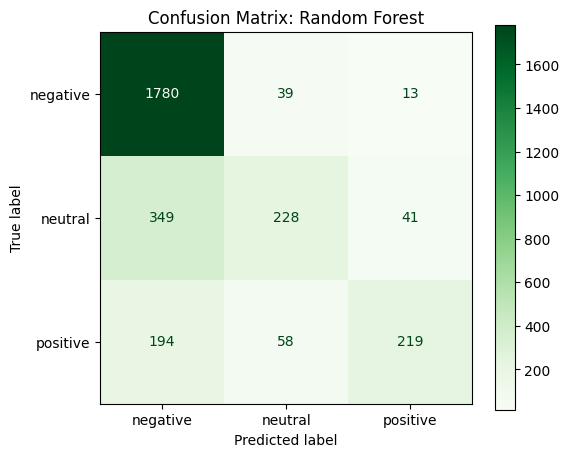

In [74]:
print("\n--- Detailed Report (Random Forest) ---")
print(classification_report(y_test_enc, y_pred_rf, target_names=class_names))

# Plot Confusion Matrix for Random Forest
plt.figure(figsize=(6, 5))
cm_rf = confusion_matrix(y_test_enc, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=class_names)
disp_rf.plot(cmap='Greens', values_format='d', ax=plt.gca())
plt.title('Confusion Matrix: Random Forest')
plt.show()


--- Detailed Report (SVM) ---
              precision    recall  f1-score   support

    negative       0.87      0.92      0.89      1832
     neutral       0.69      0.62      0.65       618
    positive       0.80      0.69      0.74       471

    accuracy                           0.82      2921
   macro avg       0.78      0.74      0.76      2921
weighted avg       0.82      0.82      0.82      2921



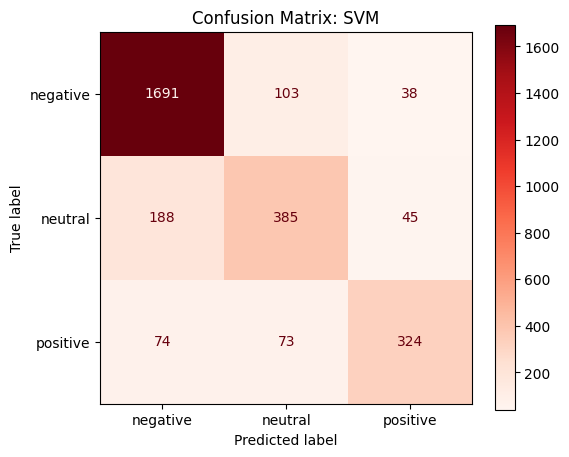

In [75]:
print("\n--- Detailed Report (SVM) ---")
print(classification_report(y_test_enc, y_pred_svm, target_names=class_names))

# Plot Confusion Matrix for SVM
plt.figure(figsize=(6, 5))
cm_svm = confusion_matrix(y_test_enc, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=class_names)
disp_svm.plot(cmap='Reds', values_format='d', ax=plt.gca())
plt.title('Confusion Matrix: SVM')
plt.show()

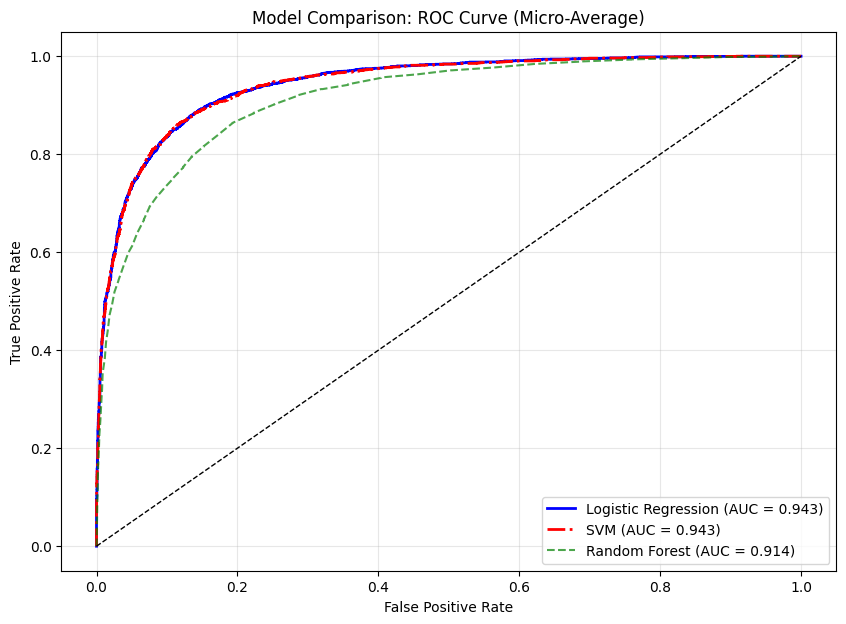

In [76]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Get Probabilities
y_prob_lr = model_lr.predict_proba(X_test)
y_prob_rf = model_rf.predict_proba(X_test)
y_prob_svm = model_svm.predict_proba(X_test) 

# Binarize labels
y_test_bin = label_binarize(y_test_enc, classes=[0, 1, 2])

# Compute ROC metrics
fpr_lr, tpr_lr, _ = roc_curve(y_test_bin.ravel(), y_prob_lr.ravel())
auc_lr = auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, _ = roc_curve(y_test_bin.ravel(), y_prob_rf.ravel())
auc_rf = auc(fpr_rf, tpr_rf)

fpr_svm, tpr_svm, _ = roc_curve(y_test_bin.ravel(), y_prob_svm.ravel())
auc_svm = auc(fpr_svm, tpr_svm)

# Plot
plt.figure(figsize=(10, 7))

plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})', color='blue', linewidth=2)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.3f})', color='red', linewidth=2, linestyle='-.')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})', color='green', linestyle='--', alpha=0.7)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model Comparison: ROC Curve (Micro-Average)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.show()

In [77]:
from sklearn.metrics import accuracy_score

print("--- Overfitting Check (Train vs Test) ---")

# Calculate accuracy on the Training Data (The data the model studied)
y_train_pred = model_lr.predict(X_train)
train_accuracy = accuracy_score(y_train_enc, y_train_pred)


print(f"Training Accuracy: {train_accuracy:.4f} ({(train_accuracy*100):.2f}%)")
print(f"Test Accuracy:     {acc_lr:.4f} ({(acc_lr*100):.2f}%)")

# Calculate the Gap
gap = train_accuracy - acc_lr
print(f"Gap:               {gap:.4f} ({(gap*100):.2f}%)")

if gap > 0.05: # If gap is bigger than 5%
    print("WARNING: Signs of Overfitting (Gap > 5%)")
else:
    print("CONCLUSION: No significant overfitting detected. The model generalizes well.")

--- Overfitting Check (Train vs Test) ---
Training Accuracy: 0.8405 (84.05%)
Test Accuracy:     0.8172 (81.72%)
Gap:               0.0233 (2.33%)
CONCLUSION: No significant overfitting detected. The model generalizes well.


In [79]:
import joblib
import os

joblib.dump(model_lr, '../models/news_classifier_logreg.pkl')
joblib.dump(encoder, '../models/label_encoder.pkl')

['../models/label_encoder.pkl']